In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections
from tqdm import trange,tqdm,notebook
import seaborn as sns

font = {        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

import pandas as pd
from CANDY import evolve
import os
import imageio
import time
import scipy as sp

In [2]:
def payoff(g):
    payoff = np.array(list(nx.get_node_attributes(g,'C').values()))
    payoff = -50*payoff*np.array([d for n,d in g.degree()])
    for n in g:
        neighbors = g.neighbors(n)
        for m in neighbors:
            if g.nodes[m]['C']:
                payoff[n] += 100
    return payoff

def payoff_n(g,n):
    pay = 0
    if g.nodes[n]['C']: 
        pay = -50*len(g.neighbors(n))
    for m in g.neighbors(n):
        if g.nodes[m]['C']:
            pay += 100
    return pay

def CP_density_discrete(g):
    cooperator = list(nx.get_node_attributes(g,'C').values())
    H = np.array([[max(c_i,c_j) for c_i in cooperator] for c_j in cooperator])
    A = nx.to_numpy_matrix(g)
    return np.multiply(A,H).sum()
def CP_density_continuous(g):
    cooperator = list(nx.get_node_attributes(g,'C').values())
    H = np.array([[c_i*c_j for c_i in cooperator] for c_j in cooperator])
    A = nx.to_numpy_matrix(g)
    return np.multiply(A,H).sum()
def CP_S(g):
    cooperator = list(nx.get_node_attributes(g,'C').values())
    H = np.array([[c_i*c_j for c_i in cooperator] for c_j in cooperator])
    A = nx.to_numpy_matrix(g)
    return np.sum(A-H)
def CP_coeff(g,samples=100):
    # uses a configuration model as null model
    def CC_norm(g):
        closeness = nx.closeness_centrality(g)
        cooperator = nx.get_node_attributes(g,'C')
        if np.sum(list(cooperator.values())) > 0:
            cc_coops = np.mean([closeness[i] for i in g if cooperator[i]])
        else:
            cc_coops = 0
        return cc_coops/np.mean(list(closeness.values()))
    empirical_cc_norm = CC_norm(g)
    d_seq = dict(g.degree)
    null_cc_norm = np.mean([CC_norm(nx.configuration_model(d_seq,create_using=nx.Graph)) for i in range(samples)])
    return empirical_cc_norm - null_cc_norm

In [18]:
def BA(N,C,rand=True,m=3):
    g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    if rand:
        cooperate = np.random.choice(range(N),size=C,replace=False)
    else:
        cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    return g

def ER(N,C,p=0.2):
    g = nx.gnp_random_graph(N,p)
    cooperate = range(C)#np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    return g

def CClique(N,C):
    g = nx.complete_graph(C)
    g.add_nodes_from(range(C,N))
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    return g

def Complete(N,C):
    g = nx.complete_graph(N)
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    return g

def SBM(N,C):
    # for ease the SBM parameters are fixed here
    g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
    cooperate = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    return g

In [10]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
payoffs=np.zeros((runs,T+1))

for r in trange(runs):
#     g1 = nx.complete_graph(C)
#     g1.add_nodes_from(range(C,N))
#     nx.set_node_attributes(g1,{n:int(n<C) for n in range(N)},'C')

    g1 = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    cooperate = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g1,{n:int(n in cooperate) for n in range(N)},'C')

    payoffs[r,:] = evolve(g1,T,strat_update=3,zeta=1,eta=2).mean(axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]/home/jbara/Documents/Warwick/PhD/Code/cooperate_defect_module.py:80: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(beta*(float(p_j-p_i))))
/home/jbara/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jbara/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


In [11]:
for r in range(runs):
    plt.plot(payoffs[r,:],lw=0.1,c='r')
    
plt.plot(payoffs.mean(axis=0))

In [5]:
def gini(p):
    tot = 0
    for x in p:
        for y in p:
            tot+=abs(x-y)
    return tot/(2*len(p)**2*p.mean())

def energy_level(C,N):
    return 25*C*(C+N-2)/N

def measure_xy(g):
    x=0
    y=0
    for u,v in list(g.edges()):
        if g.nodes[u]['C']&g.nodes[v]['C']:
            x+=1
        elif g.nodes[u]['C']|g.nodes[v]['C']:
            y+=1
    return x,y

In [5]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
xy = np.zeros((runs,T+1,2))

for run in trange(runs):
    g1 = nx.complete_graph(C)
    g1.add_nodes_from(range(C,N))
    nx.set_node_attributes(g1,{n:int(n<C) for n in range(N)},'C')
    x0,y0=measure_xy(g1)
    g = evolve(g1,T,graph=True,zeta=1,eta=1)
    for i in range(T+1):
        xy[run,i,:] = measure_xy(g[i])

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


In [12]:
import matplotlib.colors
invariant = 2*xy[:,:,0] + xy[:,:,1]
norm = matplotlib.colors.Normalize(vmin=np.min(np.min(invariant)), vmax=np.max(invariant))

In [19]:
for i in trange(T+1):
    fig,axs=plt.subplots(figsize=(10,8))
    axs.scatter(xy[:,i,0],xy[:,i,1],c=invariant[:,i],cmap='viridis',norm=norm,s=100) # current time

    axs.set_xlabel("C-C edges")
    axs.set_ylabel("C-D edges")
#     for c in np.arange(0,460,20):
#         lil_x = np.linspace(-10,400)
#         axs.plot(lil_x,c-2*lil_x,'k:',lw=0.5)
    axs.set_ylim((-10,80))
    axs.set_xlim((-10,200))
    fig.savefig(f'MISSRG/GIF/{i}.jpg',bbox_inches='tight',dpi=60)
    plt.close()

# axs[1].plot(np.arange(T+1),50*(2*X+Y)/N,c='r')
# axs[1].plot(np.arange(T+1),50*(2*xy.mean(axis=0)[:,0]+xy.mean(axis=0)[:,1])/N,c='r')

100%|██████████| 951/951 [02:12<00:00,  7.16it/s]


In [20]:
i=T+1
with imageio.get_writer('MISSRG/GIF/xy C-Clique no-invariant.gif', mode='I') as writer:
    for j in trange(i):
        image = imageio.imread(f'MISSRG/GIF/{j}.jpg')
        writer.append_data(image)

    # Remove files
for j in trange(i):
    os.remove(f'MISSRG/GIF/{j}.jpg')

100%|██████████| 951/951 [00:00<00:00, 54919.22it/s]


In [5]:
N = 20
T = int(5*N*(N-1)/2)
C = 15
# g1 = nx.generators.random_graphs.barabasi_albert_graph(N,3)
# cooperate1 = np.random.choice(range(N),size=C,replace=False,)
# nx.set_node_attributes(g1,{n:int(n in cooperate1) for n in range(N)},'C')
g=[]
for run in trange(100):
    g1 = nx.complete_graph(C)
    g1.add_nodes_from(range(C,N))
    nx.set_node_attributes(g1,{n:int(n<C) for n in range(N)},'C')
    g.append(evolve(g1,T,graph=True,zeta=1))

 27%|██▋       | 27/100 [00:21<00:56,  1.29it/s]


KeyboardInterrupt: 

In [3]:
N = 20
T = int(5*N*(N-1)/2)
C = 15
g = nx.complete_graph(C)
g.add_nodes_from(range(C,N))
nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
_=evolve(g,T,zeta=0)

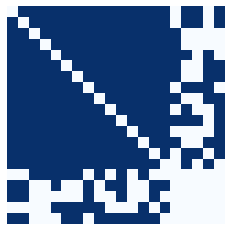

In [5]:
A=nx.adjacency_matrix(g).toarray()
plt.imshow(A,cmap='Blues')
plt.axis('off')
plt.savefig("MISSRG/Adjacency.png",bbox_inches='tight')

(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

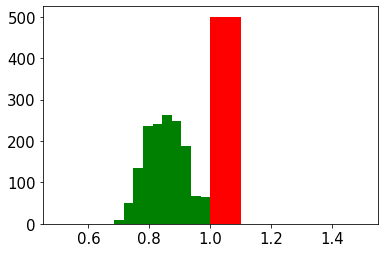

In [42]:
plt.hist(c_clustering,color='green')
plt.hist(d_clustering,color='red')

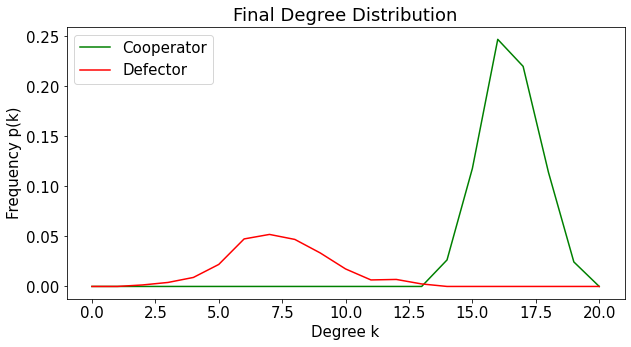

In [31]:
fig=plt.figure(figsize=(10,5))
plt.plot(np.arange(21),np.array(c_freq)/(N*100),color='green',label='Cooperator')
plt.plot(np.arange(21),np.array(d_freq)/(N*100),color='red',label='Defector')
plt.legend()
plt.xlabel("Degree k")
plt.ylabel("Frequency p(k)")
plt.title("Final Degree Distribution")
fig.savefig("MISSRG/Final Degree Distribution.png",bbox_inches='tight')

In [12]:
G=g[-1]

In [15]:
c_list = [n for n,c in nx.get_node_attributes(G[0],'C').items() if c]
d_list = [n for n in range(N) if n not in c_list]
pos=nx.shell_layout(G[0],nlist=[c_list,d_list])
i=0
c=C
while (i <T+1):
    node_att = list(nx.get_node_attributes(G[i],'C').values())
    node_col = ['g'*a + 'r'*(1-a) for a in node_att]
    nx.draw(G[i],pos=pos,node_color=node_col,width=0.5)
    plt.savefig(f'MISSRG/GIF/{i}.jpg',bbox_inches='tight',dpi=60)
    plt.close()
    i+=1
#     c=np.sum(node_att)

In [16]:
with imageio.get_writer('MISSRG/GIF/Fast Strategy C-Clique 2.gif', mode='I') as writer:
    for j in trange(i):
        image = imageio.imread(f'MISSRG/GIF/{j}.jpg')
        writer.append_data(image)

    # Remove files
for j in trange(i):
    os.remove(f'MISSRG/GIF/{j}.jpg')

100%|██████████| 951/951 [00:00<00:00, 53606.19it/s]


In [6]:
# number of edges y C-D:
χ_cd = C*(N-C)/2
y_0g = 0
y_0r = χ_cd*2
t = np.arange(T+1)
τ_g = N*(N-1)/2

y_g = χ_cd - (χ_cd - y_0g)*np.exp(-t/τ_g)
y_r = χ_cd - (χ_cd - y_0r)*np.exp(-t/τ_g)

Text(0, 0.5, 'Average Payoff $\\bar{\\pi}$')

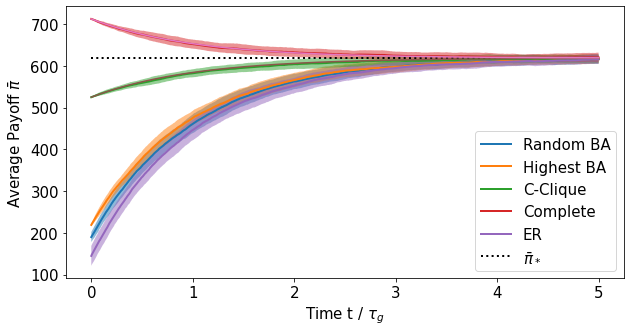

In [11]:
# c=['k','g','r']
fig = plt.figure(figsize=(10,5))
l = ['Random BA', 'Highest BA', 'C-Clique','Complete','ER']
for n in range(5):
    avg_ = avg_payoff[n,0,:,:]
    plt.fill_between(np.arange(T+1)*2/(N*(N-1)),
                     (np.mean(avg_,axis=0)-np.std(avg_,axis=0)),
                     (np.mean(avg_,axis=0)+np.std(avg_,axis=0)),alpha=0.5)
    plt.plot(t/τ_g,np.mean(avg_,axis=0),label=l[n],lw=2)
plt.plot([0,5],[25*C*(C+N-2)/N]*2,'k:',lw=2,label=r'$\bar{\pi}_*$') # For single cost to C
plt.legend()

# plt.plot(t/τ_g, 50*C*(C-1)/N + 50*y_g/N)
# plt.plot(t/τ_g, 50*C*(C-1)/N + 50*y_r/N)

# plt.yscale('log')
plt.xlabel(r'Time t / $\tau_g$')
plt.ylabel(r'Average Payoff $\bar{\pi}$')
# fig.savefig("Average Payoff Evolution.png",bbox_inches='tight')

(0.0, 0.3)

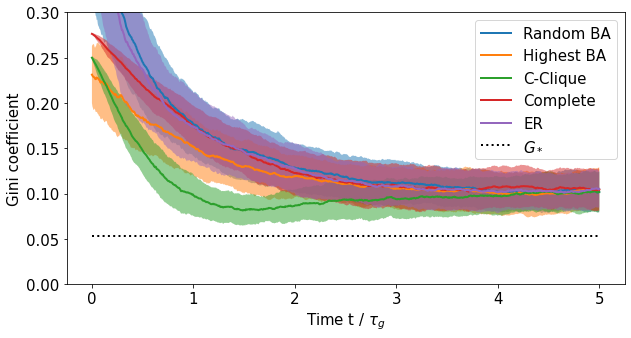

In [129]:
c=['b','orange','g','r','purple']
C=15
y_d = 50*C
y_c = 50*(C-1) - 25*(N-C)
y = 25*C*(C+N-2)/N
fig = plt.figure(figsize=(10,5))
l = ['Random BA', 'Highest BA', 'C-Clique','Complete','ER']
for n in range(5):
# n=1
    gini_ = ginis[n,:,:]
    plt.fill_between(np.arange(T+1)*2/(N*(N-1)),
                     (np.mean(gini_,axis=0)-np.std(gini_,axis=0)),
                     (np.mean(gini_,axis=0)+np.std(gini_,axis=0)),alpha=0.5)
    plt.plot(np.arange(T+1)*2/(N*(N-1)),np.mean(gini_,axis=0),label=l[n],lw=2)
#     for r in range(runs):
#         plt.plot(np.arange(T+1)*2/(N*(N-1)),gini_[r,:],c=c[n],lw=0.1)
plt.plot([0,5],[(y_d-y_c)*(N-C)*C/(y*N**2)]*2,'k:',lw=2,label=r'$G_*$') # For single cost to C
plt.legend()
# plt.yscale('log')
plt.xlabel(r'Time t / $\tau_g$')
plt.ylabel(r'Gini coefficient')
# plt.xlim([1,4])
plt.ylim([0,0.3])
# plt.yscale('log')
# fig.savefig("Average Payoff Evolution.png",bbox_inches='tight')

In [85]:
print(abs(2.7-10))

7.3


Text(0, 0.5, 'Average Defector Payoff $\\bar{\\pi}_d$')

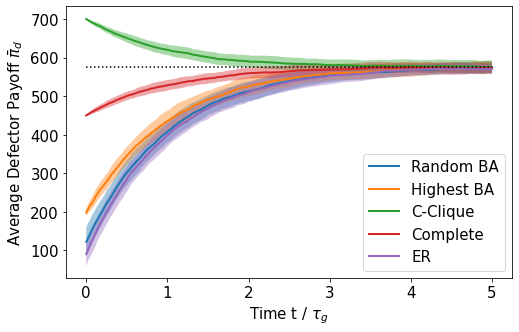

In [81]:
# c=['k','g','r']
fig = plt.figure(figsize=(8,5))
l = ['Random BA', 'Highest BA', 'C-Clique','Complete','ER']
for n in range(5):
    avg_ = avg_payoff[n,1,:,:]
    plt.fill_between(np.arange(T+1)*2/(N*(N-1)),
                     (np.mean(avg_,axis=0)-np.std(avg_,axis=0)),
                     (np.mean(avg_,axis=0)+np.std(avg_,axis=0)),alpha=0.4)
    plt.plot(np.arange(T+1)*2/(N*(N-1)),np.mean(avg_,axis=0),label=l[n],lw=2)
# plt.plot([0,2*T/((N-1)*N)],[50*C]*2,'k:') # For defector
plt.plot([0,2*T/((N-1)*N)],[50*(C-1) - 50*(N-C)/(2)]*2,'k:') # For cooperator
plt.legend(loc='lower right')
# plt.yscale('log')
plt.xlabel(r'Time t / $\tau_g$')
plt.ylabel(r'Average Defector Payoff $\bar{\pi}_d$')
# fig.savefig("Average Defector Payoff Evolution.png",bbox_inches='tight')

In [53]:
avg_ = avg_payoff[3,0,:,:]
avg_c = avg_payoff[3,1,:,:]
avg_d = avg_payoff[3,2,:,:]
plt.plot(np.mean(avg_,axis=0))
plt.plot(np.mean((avg_c*C+avg_d*(N-C))/N,axis=0))

Text(0.5, 0, 'Degree')

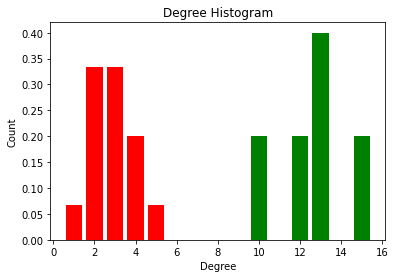

In [98]:
degree_sequence_C = sorted([d for n, d in g.degree() if g.nodes[n]['C']], 
                           reverse=True)  # degree sequence
degreeCountC = collections.Counter(degree_sequence_C)
degC, cntC = zip(*degreeCountC.items())

degree_sequence_D = sorted([d for n, d in g.degree() if not g.nodes[n]['C']], 
                           reverse=True)  # degree sequence
degreeCountD = collections.Counter(degree_sequence_D)
degD, cntD = zip(*degreeCountD.items())

fig, ax = plt.subplots()
plt.bar(degC, np.array(cntC)/sum(cntC), width=0.80, color="g")
plt.bar(degD, np.array(cntD)/sum(cntD), width=0.80, color="r")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.yscale('log')
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

In [99]:
degree_sequence = sorted([d for n, d in g.degree()], 
                           reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, np.array(cnt)/sum(cnt), width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.yscale('log')
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

Text(0.5, 0, 'Degree')

In [100]:
nx.draw(g,labels=(nx.get_node_attributes(g,'C')))

# Changing strategies

In [9]:
N = 20
τ_g = 2*round(N*(N-1)/2)
runs=100
avg_payoff=np.zeros((runs,(τ_g+1)*5))
C = np.random.randint(1,N+1,size=5)

for r in trange(runs):
    g = nx.complete_graph(N)
#     g = nx.complete_graph(C)
#     g.add_nodes_from(range(C,N))
    nx.set_node_attributes(g,{n:int(n<C[0]) for n in range(N)},'C')
#     g_ghost = g.copy()

    for i in range(4):
        avg_payoff[r,i*(τ_g+1):(i+1)*(τ_g+1)] = np.mean(evolve(g,τ_g),axis=0)
#         avg_payoff[r,1,i*(τ_g+1):(i+1)*(τ_g+1)] = np.mean(evolve(g_ghost,τ_g),axis=0)
#         g_ghost = g.copy()
        nx.set_node_attributes(g,{n:int(n<C[i+1]) for n in range(N)},'C')

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Text(0, 0.5, 'Average Payoff $\\bar{\\pi}$')

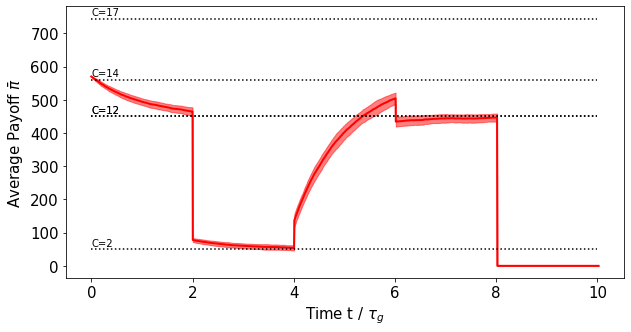

In [10]:
fig=plt.figure(figsize=(10,5))
avg_ = avg_payoff
plt.fill_between(2*np.arange(5*(τ_g+1))/(τ_g),
                     (np.mean(avg_,axis=0)-np.std(avg_,axis=0)),
                     (np.mean(avg_,axis=0)+np.std(avg_,axis=0)),alpha=0.5,color='r')
plt.plot(2*np.arange(5*(τ_g+1))/(τ_g),np.mean(avg_,axis=0),c='r',lw=2)

for i in range(5):
    plt.plot([0,10],[25*(C[i])*(C[i]+N-2)/N]*2,'k:')
    plt.text(0,25*(C[i])*(C[i]+N-2)/N+10,'C=%i'%(C[i]),fontsize=10)

plt.xlabel(r'Time t / $\tau_g$')
plt.ylabel(r'Average Payoff $\bar{\pi}$')
# fig.savefig("Avg Payoff Staircase.png",bbox_inches='tight')

In [11]:
print(C)

[12  2 14 12 17]


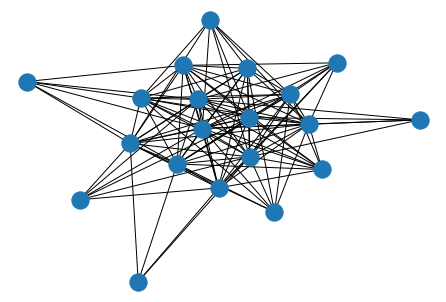

In [12]:
nx.draw(g,labels)

# Data analysis

# Strategy imitation

In [155]:
def initial_count(g):
    x = 0
    y = 0
    for e in g.edges():
        if g.nodes[e[0]]['C']:
            if g.nodes[e[1]]['C']:
                x+=1
            else:
                y+=1
    return x,y

In [173]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
avg_payoffs = np.zeros((runs,T+1))
x,y = 0,0

for r in trange(runs):
    g = nx.complete_graph(C)
    g.add_nodes_from(range(C,N))
#     g = nx.gnp_random_graph(N,0.2)
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    x0,y0 = initial_count(g)
    x+=x0
    y+=y0
    payoffs = evolve(g,T,graph=False,zeta=1,eta=5)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)

x = x/runs
y = y/runs

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


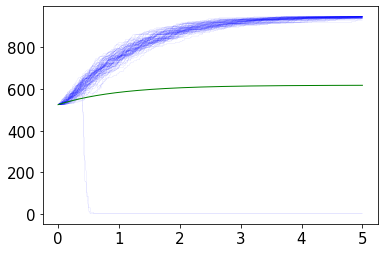

In [174]:
χ_cd = C*(N-C)/2
χ_cc = C*(C-1)/2
χ = 2*χ_cc + χ_cd

χ_cd2 = 20*(N-20)/2
χ_cc2 = 20*(20-1)/2
χ2 = 2*χ_cc2 + χ_cd2

t = np.arange(T+1)
τ_g = N*(N-1)/2

y_g = χ - (χ - (2*x+y))*np.exp(-t/τ_g)
# y_r = χ2 - (χ2 - (2*x+y))*np.exp(-t/τ_g)

# plt.plot(t/τ_g,np.mean(avg_payoffs,axis=0),c='b')
for r in range(runs):
    plt.plot(t/τ_g,avg_payoffs[r,:],c='b',lw=0.05)
# plt.fill_between(t/τ_g,
#                      (np.mean(avg_payoffs,axis=0)-np.std(avg_payoffs,axis=0)),
#                      (np.mean(avg_payoffs,axis=0)+np.std(avg_payoffs,axis=0)),alpha=0.5)
plt.plot(t/τ_g,y_g*50/N,c='g',lw=1)
# plt.plot(t/τ_g,y_r*50/N,c='r',lw=1)
# plt.plot(t/τ_g,pibar(C,N,T,C*(C-1)/2,0),c='r',lw=1)
# plt.plot(t/τ_g,pibar(18,N,T,N*(N-1)/2,0),c='k',lw=1)

Graphs = 'Random BA', 'Highest BA', 'C-Clique', 'Complete', 'ER'

$\tau_s/\tau_g$ = 1/5, 1/2, 1, 5, 10, $\infty$

In [8]:
# Random BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Random BA/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [43]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    cooperate = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Random BA/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


In [9]:
# Highest BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Highest BA/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


In [44]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Highest BA/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


In [2]:
# C-Clique

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(C)
        g.add_nodes_from(range(C,N))
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
#     pd.DataFrame(avg_payoffs).to_csv('Data/C-Clique/'+s[i]+'.csv',header=None,index=None)

  2%|▏         | 2/100 [00:02<01:57,  1.20s/it]


KeyboardInterrupt: 

In [45]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.complete_graph(C)
    g.add_nodes_from(range(C,N))
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/C-Clique/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [11]:
# Complete

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(N)
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Complete/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


In [46]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.complete_graph(N)
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Complete/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


In [12]:
# ER

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.gnp_random_graph(N,0.2)
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/ER/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


In [47]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.gnp_random_graph(N,0.2)
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/ER/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


In [55]:
# Cycle

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,0]
eta = [5,2,1,1,1,1]
s = ['0.2','0.5','1','5','10','inf']

for i in range(6):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.cycle_graph(N)
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i])
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Cycle/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


In [48]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.cycle_graph(N)
    nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=50,eta=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Cycle/50.csv',header=None,index=None)

100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


In [11]:
# SBM, 2 groups of 10, p_rr = 0.8, p_rs=0.2
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=1)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/SBM/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [8]:
# SBM, 2 groups of 10, p_rr = 0.8, p_rs=0.2
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = 100
eta = 1
s = '100'

avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
    cooperate = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=zeta,eta=eta,strat_update=1)
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/SBM/100.csv',header=None,index=None)

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


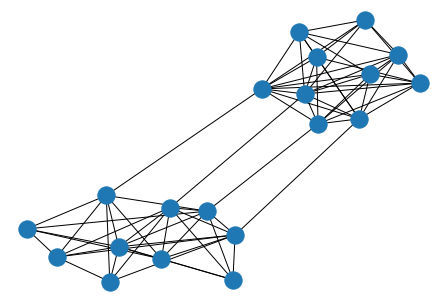

In [9]:
g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
nx.draw(g)

In [10]:
3%3

0

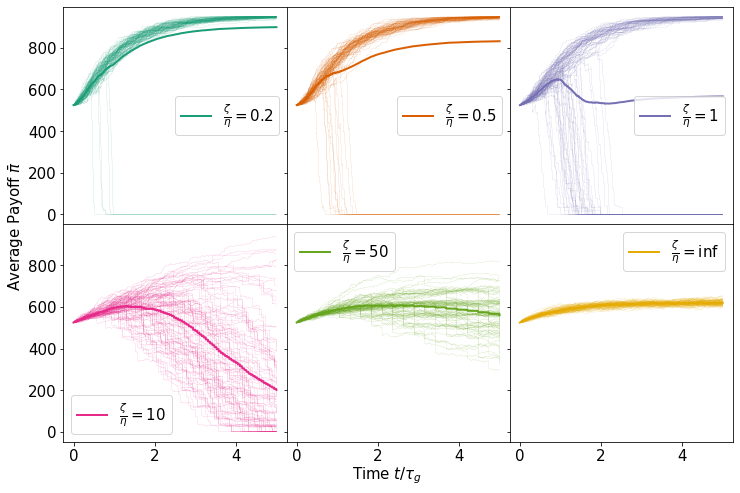

In [29]:
name = 'C-Clique'
s = ['0.2','0.5','1','10','50','inf']
IC = [pd.read_csv('Data/'+name+'/'+s[i]+'.csv',header=None).to_numpy() for i in range(6)]
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
# c = ['r','g','b','orange','purple','k']
fig,axs = plt.subplots(figsize=(12,8),ncols=3,nrows=2,sharey=True,sharex=True)
c=sns.color_palette('Dark2',6)
for i,ic in enumerate(IC):
    for r in range(runs):
        axs[i//3,i%3].plot(np.arange(T+1)/(T/5),ic[r,:],lw=0.09,c=c[i])
        
#     plt.fill_between(np.arange(T+1)/(T/5),
#                      np.mean(ic,axis=0)-np.std(ic,axis=0),
#                      np.mean(ic,axis=0)+np.std(ic,axis=0),
#                      color=c[i],alpha=0.2)

#     plt.fill_between(np.arange(T+1)/(T/5),
#                      np.min(ic,axis=0),
#                      np.max(ic,axis=0),
#                      color=c[i],alpha=0.2)
#     axs[i//3,i%3].plot(np.arange(T+1)/(T/5),np.mean(ic,axis=0),c='k',lw=2)
    axs[i//3,i%3].plot(np.arange(T+1)/(T/5),np.mean(ic,axis=0),c=c[i],label=r'$\frac{\zeta}{\eta}=$'+s[i],lw=2)
    axs[i//3,i%3].set_xticks([0,2,4])
    axs[i//3,i%3].legend()
#     plt.plot(np.arange(T+1)/(T/5),np.median(ic,axis=0),c=c[i],label=s[i])

# plt.legend(ncol=1,loc=(0.02,0.2))
# plt.plot(np.arange(T+1)/(T/5),energy_evolution(C,N,T,C*(C-1)/2,0),c='yellow')
# plt.plot(np.arange(T+1)/(T/5),energy_evolution(N,N,T,C*(C-1)/2,0),c='yellow')
# plt.yscale('log')
# plt.xlim([0,1])
# plt.ylim([0,500])
fig.subplots_adjust(wspace=0,hspace=0)
# axs[0].set_yticks([0,250,500,750])
# axs[0].set_ylabel(r"Average Payoff $\bar{\pi}$")
fig.text(0.5, 0.06, r"Time $t / \tau_g$", ha='center')
fig.text(0.06, 0.5, r"Average Payoff $\bar{\pi}$", va='center', rotation='vertical')
fig.savefig('Data/'+name+'/'+name+'_evol_2x3.png',bbox_inches='tight')
# fig.tight_layout()

Text(0.5, 0.07, 'Time $t/\\tau_g$')

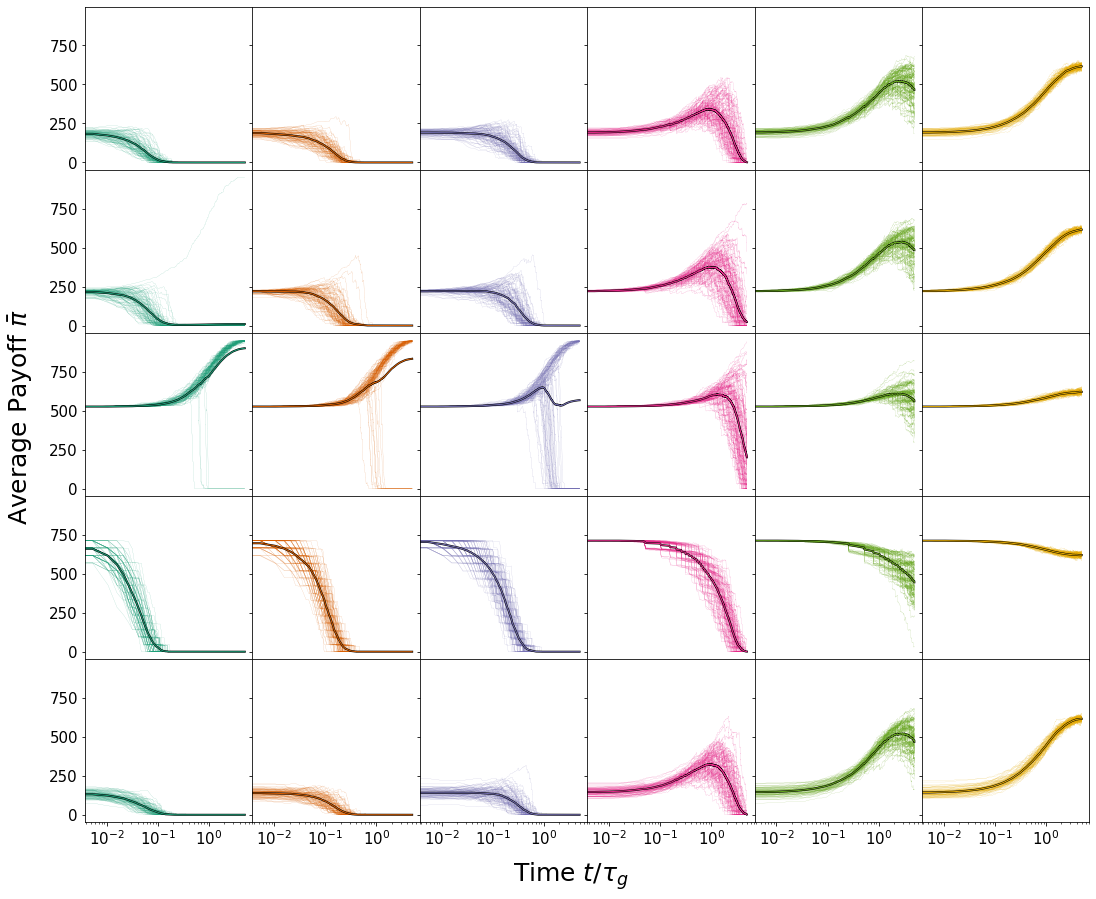

In [7]:
c=sns.color_palette('Dark2',6)
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
s = ['0.2','0.5','1','10','50','inf']
names=['Random BA','Highest BA','C-Clique','Complete','ER']

fig,axs = plt.subplots(figsize=(18,15),ncols=len(s),nrows=len(names),sharey=True,sharex=True)
for j in range(len(names)):
    name = names[j]
    IC = [pd.read_csv('Data/Imitate/'+name+'/'+s[i]+'.csv',header=None).to_numpy() for i in range(6)]
    # c = ['r','g','b','orange','purple','k']
    for i,ic in enumerate(IC):
        for r in range(runs):
            axs[j,i].plot(np.arange(T+1)*5/T,ic[r,:],lw=0.09,c=c[i])
        axs[j,i].plot(np.arange(T+1)*5/T,np.mean(ic,axis=0),c='k',lw=2)
        axs[j,i].plot(np.arange(T+1)*5/T,np.mean(ic,axis=0),c=c[i],label=s[i],lw=1)
#         axs[j,i].set_xticks([0,2,4])
        axs[j,i].set_xscale('log')
#         axs[j,i].set_xlim([1,T])
# axs[0,i for i in range()].legend(title=r'$\zeta/\eta$',ncol=2)
fig.subplots_adjust(wspace=0,hspace=0)
fig.text(0.065, 0.5, r"Average Payoff $\bar{\pi}$", va='center', rotation='vertical',fontsize=25)
fig.text(0.5, 0.07, r"Time $t/\tau_g$", ha='center',fontsize=25)

# fig.savefig('Data/all_evol_nocycle50.png',bbox_inches='tight')
# fig.tight_layout()

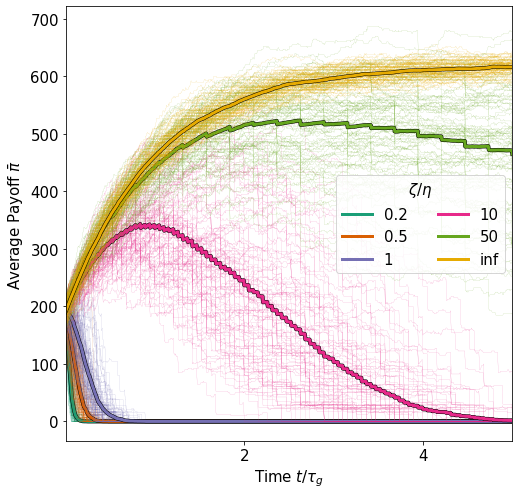

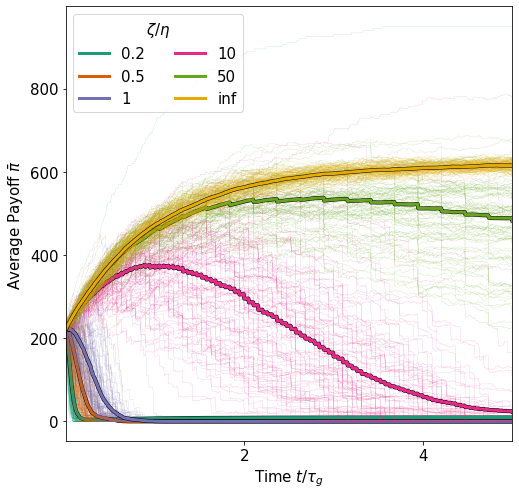

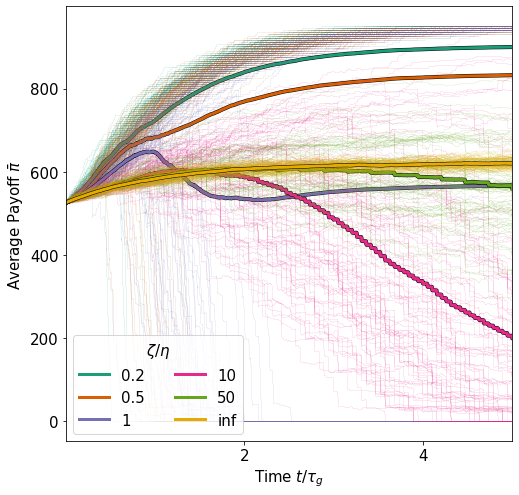

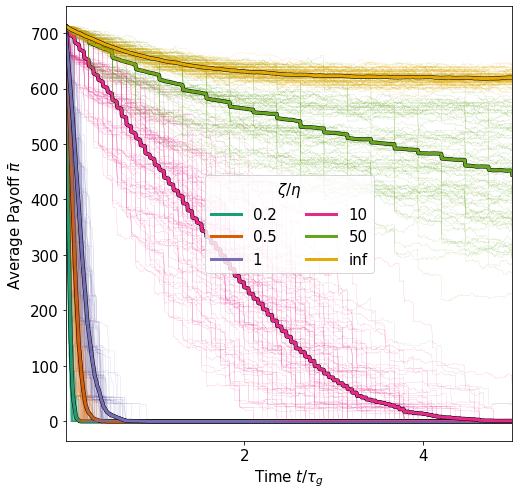

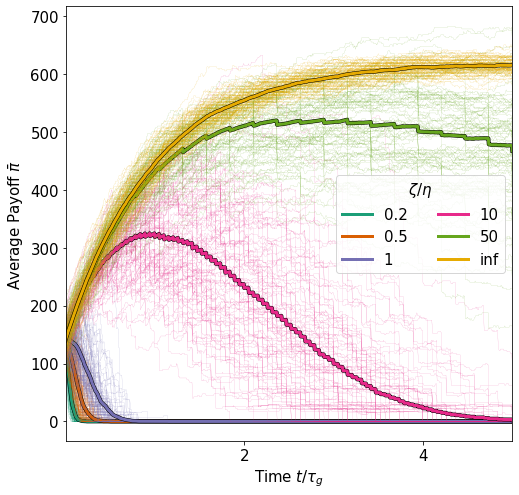

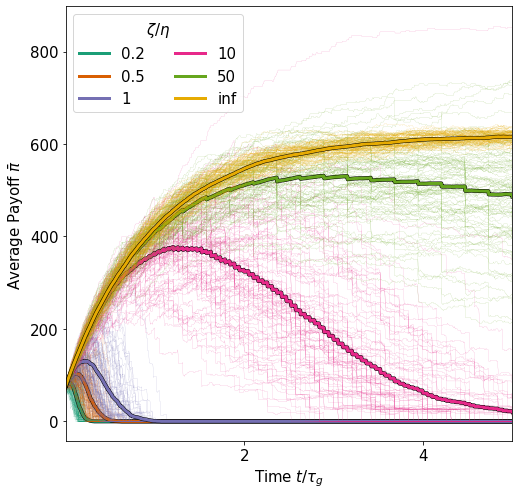

In [50]:
c=sns.color_palette('Dark2',6)
names=['Random BA','Highest BA','C-Clique','Complete','ER','Cycle']
for j in range(len(names)):
    fig = plt.figure(figsize=(8,8))
    name = names[j]
    IC = [pd.read_csv('Data/'+name+'/'+s[i]+'.csv',header=None).to_numpy() for i in range(6)]
    for i,ic in enumerate(IC):
        for r in range(runs):
            plt.plot(np.arange(T+1)/(T/5),ic[r,:],lw=0.1,c=c[i])
        plt.plot(np.arange(T+1)/(T/5),np.mean(ic,axis=0),c='k',lw=4)
        plt.plot(np.arange(T+1)/(T/5),np.mean(ic,axis=0),c=c[i],label=s[i],lw=3)
    plt.legend(title=r'$\zeta/\eta$',ncol=2)
    plt.xticks([0,2,4])
    plt.xlim([5/T,5])
    plt.ylabel(r"Average Payoff $\bar{\pi}$")
    plt.xlabel(r"Time $t / \tau_g$")
    fig.savefig('Data/'+name+'/'+name+'_single_evol.png',bbox_inches='tight')

# BA

In [5]:
N = 50
T = int(5*N*(N-1)/2)
runs = 100
avg_payoff=np.zeros((5,3,runs,T+1))
# ginis = np.zeros((5,runs,T+1))
C = 30

for run in trange(runs):
    # random assignment, k = 3
    g1 = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    cooperate1 = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g1,{n:int(n in cooperate1) for n in range(N)},'C')
    payoffs1 = evolve(g1,T,graph=False)
    
    # highest degree, k = 3
    g2 = nx.generators.random_graphs.barabasi_albert_graph(N,3)
    cooperate2 = np.array([d for n,d in g2.degree()]).argsort()[-C:][::-1]
    nx.set_node_attributes(g2,{n:int(n in cooperate2) for n in range(N)},'C')
    payoffs2 = evolve(g2,T,graph=False)
    
    # random assignment, k = 10
    g3 = nx.generators.random_graphs.barabasi_albert_graph(N,10)
    cooperate3 = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g3,{n:int(n in cooperate3) for n in range(N)},'C')
    payoffs3 = evolve(g3,T,graph=False)
    
    # highest degree, k = 3
    g4 = nx.generators.random_graphs.barabasi_albert_graph(N,10)
    cooperate4 = np.array([d for n,d in g2.degree()]).argsort()[-C:][::-1]
    nx.set_node_attributes(g4,{n:int(n in cooperate4) for n in range(N)},'C')
    payoffs4 = evolve(g4,T,graph=False)
    
    # ER graph
    g5 = nx.gnp_random_graph(N,0.2)
    cooperate5 = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g5,{n:int(n in cooperate5) for n in range(N)},'C')
    payoffs5 = evolve(g5,T,graph=False)
    
    payoffs = [payoffs1,payoffs2,payoffs3,payoffs4,payoffs5]
    cooperate = [cooperate1,cooperate2,range(C),range(C),cooperate5]
    
    for i in range(5):
        avg_payoff[i,0,run,:] = np.mean(payoffs[i],axis=0)
        avg_payoff[i,1,run,:] = np.mean(payoffs[i][cooperate[i],:],axis=0)
        avg_payoff[i,2,run,:] = np.mean(payoffs[i][[n for n in range(N) 
                                               if not n in cooperate[i]],:],axis=0)
# nx.draw(g,labels=(nx.get_node_attributes(g,'C')))

100%|██████████| 100/100 [1:21:45<00:00, 49.05s/it]


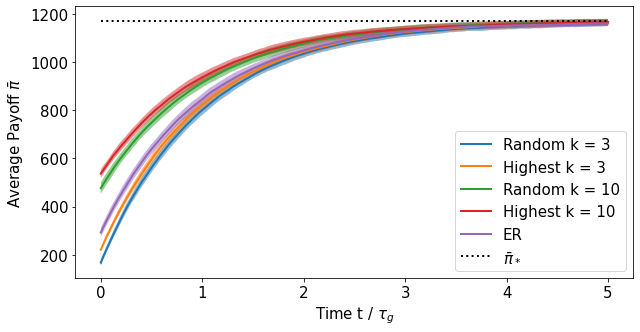

In [22]:
# c=['k','g','r']
fig = plt.figure(figsize=(10,5))
l = ['Random k = 3', 'Highest k = 3', 'Random k = 10','Highest k = 10','ER']
t=np.arange(T+1)
τ_g = N*(N-1)/2
for n in range(5):
    avg_ = avg_payoff[n,0,:,:]
    plt.fill_between(np.arange(T+1)*2/(N*(N-1)),
                     (np.mean(avg_,axis=0)-np.std(avg_,axis=0)),
                     (np.mean(avg_,axis=0)+np.std(avg_,axis=0)),alpha=0.5)
    plt.plot(t/τ_g,np.mean(avg_,axis=0),label=l[n],lw=2)
plt.plot([0,5],[25*C*(C+N-2)/N]*2,'k:',lw=2,label=r'$\bar{\pi}_*$') # For single cost to C
plt.legend()

# plt.plot(t/τ_g, 50*C*(C-1)/N + 50*y_g/N)
# plt.plot(t/τ_g, 50*C*(C-1)/N + 50*y_r/N)

# plt.yscale('log')
# plt.xlim([0,1])
# plt.xscale('log')
# plt.ylim([100,1000])
plt.xlabel(r'Time t / $\tau_g$')
plt.ylabel(r'Average Payoff $\bar{\pi}$')
fig.savefig("BA_N50 Evolution t5.png",bbox_inches='tight')

# Imitate2 electric boogaloo
imitate when fraction of neighbors are the opposite above a threshold

In [8]:
# C-Clique

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(C)
        g.add_nodes_from(range(C,N))
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/C-Clique/v0208_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


In [12]:
# ER

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.gnp_random_graph(N,0.2)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.5,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/ER/'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


In [13]:
# Random BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Random BA/v0208_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [16]:
# Highest BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Highest BA/v0208_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [10]:
# Complete

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 16

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(N)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2)#,v={1:0.2,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Complete/C16_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


In [13]:
# SBM, 2 groups of 10, p_rr = 0.8, p_rs=0.05
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

for i in range(7):
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/SBM/v0208_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


# Drawing Imitate2

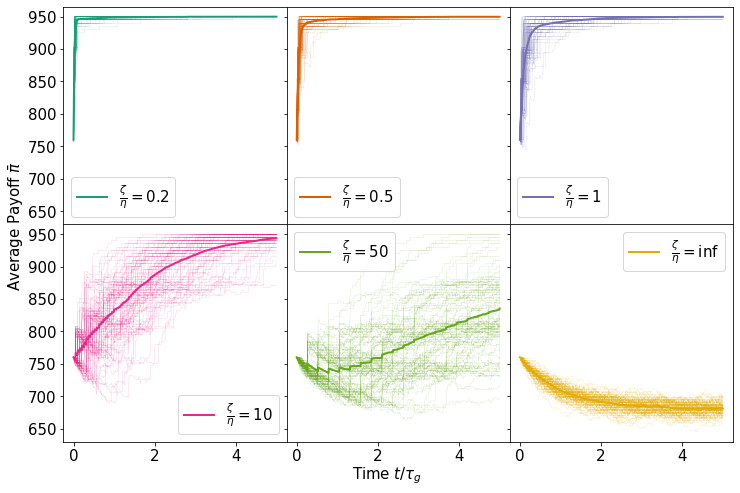

In [11]:
name = 'Complete'
s = ['0.2','0.5','1','10','50','inf']
IC = [pd.read_csv('Data/Imitate2/'+name+'/C16_'+s[i]+'.csv',header=None).to_numpy() for i in range(6)]
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
# c = ['r','g','b','orange','purple','k']
fig,axs = plt.subplots(figsize=(12,8),ncols=3,nrows=2,sharey=True,sharex=True)
c=sns.color_palette('Dark2',6)
for i,ic in enumerate(IC):
    for r in range(runs):
        axs[i//3,i%3].plot(np.arange(T+1)/(T/5),ic[r,:],lw=0.09,c=c[i])
    axs[i//3,i%3].plot(np.arange(T+1)/(T/5),np.mean(ic,axis=0),c=c[i],label=r'$\frac{\zeta}{\eta}=$'+s[i],lw=2)
    axs[i//3,i%3].set_xticks([0,2,4])
    axs[i//3,i%3].legend()

fig.subplots_adjust(wspace=0,hspace=0)
fig.text(0.5, 0.06, r"Time $t / \tau_g$", ha='center')
fig.text(0.06, 0.5, r"Average Payoff $\bar{\pi}$", va='center', rotation='vertical')
fig.savefig('Data/Imitate2/'+name+'/'+name+'_C16_evol_2x3.png',bbox_inches='tight')

In [22]:
N = 20
T = int(10*N*(N-1)/2)
runs = 100
C = 15
avg_payoffs = np.zeros((runs,T+1))
for r in trange(runs):
    g = nx.complete_graph(N)
    cooperate = np.random.choice(range(N),size=C,replace=False)
    nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
    payoffs = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})
    avg_payoffs[r,:] = np.mean(payoffs,axis=0)
pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Complete/v0208_'+s[i]+'_T10.csv',header=None,index=None)

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


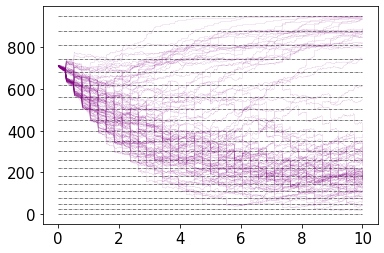

In [51]:
for c in range(N+1):
    plt.plot([0,10],[energy_level(c,N)]*2,c='k',ls='-.',lw=0.5)

for r in range(runs):
    plt.plot(np.arange(T+1)/(T/10),avg_payoffs[r,:],c='purple',lw=0.09)

In [30]:
g = nx.complete_graph(N)
cooperate = np.random.choice(range(N),size=C,replace=False)
nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
G = evolve(g,T,graph=True,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})

In [46]:
pos = nx.spring_layout(G[0])
for t in trange(T+1):
    fig=plt.figure(figsize=(6,6))
    strat = nx.get_node_attributes(G[t],'C') #dict
    color = [strat[i]*'g'+(1-strat[i])*'r' for i in range(N)]
    nx.draw(G[t],pos=pos,node_color=color)
    fig.savefig('Data/Imitate2/Complete/GIF/'+str(t)+'.png',bbox_inches='tight',dpi=50)
    plt.close()

100%|██████████| 1901/1901 [02:51<00:00, 11.09it/s]


In [47]:
import imageio
images = []
for t in trange(T+1):
    images.append(imageio.imread('Data/Imitate2/Complete/GIF/'+str(t)+'.png'))
imageio.mimsave('Data/Imitate2/Complete/example.gif', images)

100%|██████████| 1901/1901 [00:06<00:00, 275.36it/s]


# Changing C for highest BA with imitate

In [7]:
# Highest BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = range(10,N)

for c in C:
    avg_payoffs = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.array([d for n,d in g.degree()]).argsort()[-c:][::-1]
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs = evolve(g,T,graph=False,zeta=1,eta=5)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Highest BA/Different C/Ratio 0.2/'+str(c)+'.csv',header=None,index=None)

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Text(0, 0.5, 'Average Payoff $\\bar{\\pi}$')

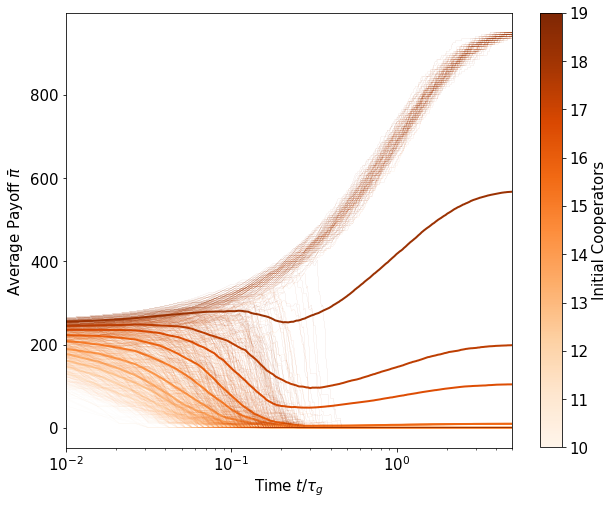

In [59]:
fig = plt.figure(figsize=(10,8))
col=sns.color_palette('Oranges',len(C))
col_cmap = sns.color_palette('Oranges',len(C),as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=col_cmap,norm=matplotlib.colors.Normalize(vmin=10,vmax=19))
# files=[pd.read_csv('Data/Imitate/Highest BA/Different C/'+str(c)+'.csv',header=None).to_numpy() for c in C]
for i,c in enumerate(C):
    file = pd.read_csv('Data/Imitate/Highest BA/Different C/Ratio 0.2/'+str(c)+'.csv',header=None).to_numpy()
    for r in range(runs):
        plt.plot(np.arange(T+1)/(T/5),file[r,:],c=col[i],lw=0.05)
    plt.plot(np.arange(T+1)/(T/5),np.mean(file,axis=0),c=col[i],label=c,lw=2)
plt.colorbar(sm,label="Initial Cooperators")
plt.xlim([0.01,5])
plt.xscale('log')
plt.xlabel(r"Time $t / \tau_g$")
plt.ylabel(r"Average Payoff $\bar{\pi}$")
# fig.savefig('Data/Imitate/Highest BA/Different C/Ratio 10/evolution10.png',bbox_inches='tight')

# large sbm

In [93]:
# SBM, 2 groups of 10, p_rr = 0.8, p_rs=0.2
N = 40
T = int(5*N*(N-1)/2)
# runs = 100
C = 18

zeta = [1,1,1,5,10,50,0]
eta = [5,2,1,1,1,1,1]
s = ['0.2','0.5','1','5','10','50','inf']

G = nx.stochastic_block_model([10,10,10,10],[[0.8,0.02,0.02,0.02],[0.02,0.8,0.02,0.02],
                                            [0.02,0.02,0.8,0.02],[0.02,0.02,0.02,0.8]])
# cooperate = np.random.choice(range(N),size=C,replace=False)
# cooperate = range(C)
cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
nx.set_node_attributes(G,{n:int(n in cooperate) for n in range(N)},'C')
# G = [g.copy() for i in range(7)]
payoffs=np.zeros((7,40,T+1))
for i in trange(7):
    g=G.copy()
    payoffs[i,:,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],strat_update=2,v={1:0.2,0:0.8})

100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


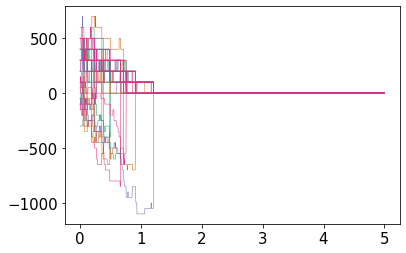

In [101]:
c=sns.color_palette('Dark2',4)
# node_c = [c[0]]*10 + [c[1]]*10 + [c[2]]*10 + [c[3]]*10
i = 4
for n in range(N):
    plt.plot(np.arange(T+1)/(T/5),payoffs[i,n,:],c=c[n//10],lw=0.5)
# for j in range(4):
#     pays = payoffs[i,j*10:(j+1)*10,:]
#     plt.plot(np.arange(T+1)/(T/5),np.mean(pays,axis=0),c=c[j],lw=0.5,label=str(j))
# plt.xlim([0,0.5])
# plt.legend()

# Experiment 2 - measuring cooperator rate too

In [6]:
# C-Clique

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(C)
        g.add_nodes_from(range(C,N))
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/C-Clique/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/C-Clique/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


In [7]:
# Complete
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.complete_graph(N)
#         g.add_nodes_from(range(C,N))
        nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/Complete/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/Complete/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


In [8]:
# ER
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.gnp_random_graph(N,0.2)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/ER/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/ER/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [9]:
# Random BA
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/Random BA/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/Random BA/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [5]:
# Highest BA
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
        cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/Highest BA/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/Highest BA/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


In [10]:
# SBM, 2 groups of 10, p_rr = 0.8, p_rs=0.05
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/SBM/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/SBM/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


In [11]:
# Cycle

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [15,20]#[1,1,1,5,10,50,0]
eta = [1,1]#[5,2,1,1,1,1,1]
s = ['15','20']#['0.2','0.5','1','5','10','50','inf']

for i in range(len(zeta)):
    avg_payoffs = np.zeros((runs,T+1))
    cooperators = np.zeros((runs,T+1))
    for r in trange(runs):
        g = nx.cycle_graph(N)
        cooperate = np.random.choice(range(N),size=C,replace=False)
        nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
        payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Imitate/Experiment 2/Cycle/payoff_'+s[i]+'.csv',header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Imitate/Experiment 2/Cycle/cooperator_'+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


# Experiment 2 - Imitate 2

In [7]:
# C-Clique

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.complete_graph(C)
            g.add_nodes_from(range(C,N))
            nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/C-Clique/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/C-Clique/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


In [8]:
# Complete

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.complete_graph(N)
            nx.set_node_attributes(g,{n:int(n<C) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/Complete/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/Complete/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


In [9]:
# ER

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.gnp_random_graph(N,0.2)
            cooperate = np.random.choice(range(N),size=C,replace=False)
            nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/ER/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/ER/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


In [10]:
# Random BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
            cooperate = np.random.choice(range(N),size=C,replace=False)
            nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/Random BA/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/Random BA/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


In [11]:
# Highest BA

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.generators.random_graphs.barabasi_albert_graph(N,3)
            cooperate = np.array([d for n,d in g.degree()]).argsort()[-C:][::-1]
            nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/Highest BA/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/Highest BA/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


In [12]:
# SBM

N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [2,15,20,25,100]
eta = [1,1,1,1,1]
s = ['2','15','20','25','100']

v_c = [0.5,0.2]
extra = ['','v0208_']
for j in range(2):
    for i in range(len(s)):
        avg_payoffs = np.zeros((runs,T+1))
        cooperators = np.zeros((runs,T+1))
        for r in trange(runs):
            g = nx.stochastic_block_model([10,10],[[0.8,0.05],[0.05,0.8]])
            cooperate = np.random.choice(range(N),size=C,replace=False)
            nx.set_node_attributes(g,{n:int(n in cooperate) for n in range(N)},'C')
            payoffs,cooperators[r,:] = evolve(g,T,graph=False,zeta=zeta[i],eta=eta[i],cooperator=True,strat_update=2,v={1:v_c[j],0:0.8})
            avg_payoffs[r,:] = np.mean(payoffs,axis=0)
        pd.DataFrame(avg_payoffs).to_csv('Data/Imitate2/Experiment 2/SBM/payoff_'+extra[j]+s[i]+'.csv',header=None,index=None)
        pd.DataFrame(cooperators).to_csv('Data/Imitate2/Experiment 2/SBM/cooperator_'+extra[j]+s[i]+'.csv',header=None,index=None)

100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


# sans strat, comparing DE's

In [10]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15
names=['rBA','hBA','ER','CClique','Complete','SBM']
avg_payoffs=np.zeros((len(names),runs,T+1))
for r in trange(runs):
    G = [BA(N,C,rand=True),BA(N,C,rand=False),ER(N,C),
         CClique(N,C),Complete(N,C),SBM(N,C)] # 2BAs, ER, CClique, Complete, SBM
    for i,g in enumerate(G):
        avg_payoffs[i,r,:]=evolve(g,T,zeta=0).mean(axis=0)

100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


In [12]:
for i in range(len(names)):
    pd.DataFrame(avg_payoffs[i,:,:]).to_csv('Data/FixedStrategy/'+names[i]+'.csv',header=None,index=None)

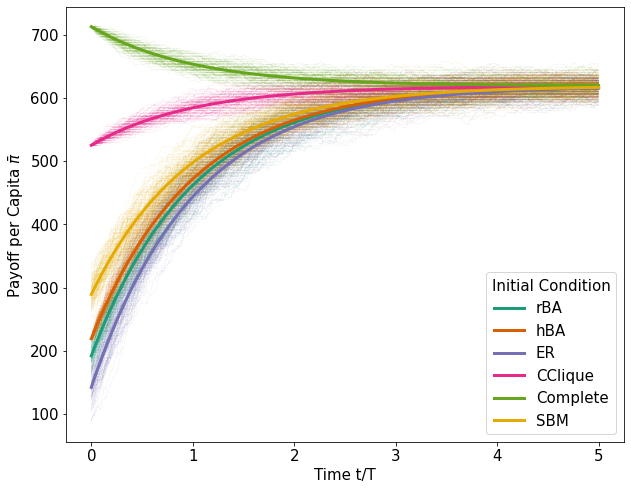

In [70]:
color=sns.color_palette('Dark2',6)
t = np.arange(T+1)

fig=plt.figure(figsize=(10,8))
for i in range(len(names)):
    for j in range(runs):
        plt.plot(t/(T/5),avg_payoffs[i,j,:],color=color[i],lw=0.05,zorder=0)
#     plt.plot(t/(T/5),avg_payoffs[i,:,:].mean(axis=0),color=color[i])
#     plt.fill_between(t/(T/5),
#                      (avg_payoffs[i,:,:].mean(axis=0)-avg_payoffs[i,:,:].std(axis=0)),
#                      (avg_payoffs[i,:,:].mean(axis=0)+avg_payoffs[i,:,:].std(axis=0)),alpha=0.3,color=color[i])
    pi0 = avg_payoffs[i,:,:].mean(axis=0)[0]
    pi = (pi0-pi_star)*np.exp(-t/τ_g)+pi_star
    plt.plot(t/(T/5),pi,color=color[i],lw=3,label=names[i],zorder=1)

plt.xlabel("Time t/T")
plt.ylabel(r"Payoff per Capita $\bar{\pi}$")
plt.legend(title='Initial Condition')
fig.gca().set_rasterized(True)
fig.savefig("Data/FixedStrategy/ModelPredictions with Simulations.pdf")

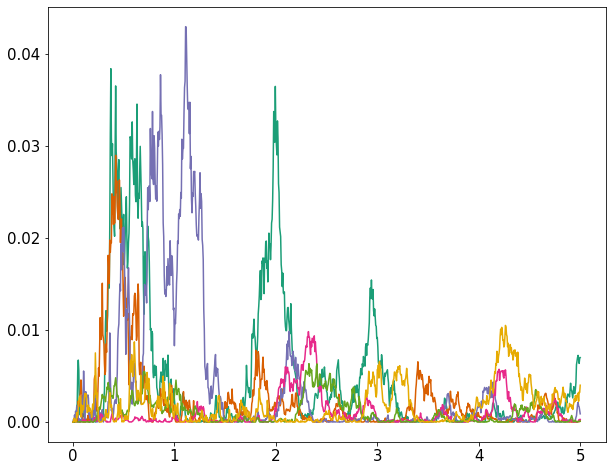

In [40]:
fig=plt.figure(figsize=(10,8))
pi_star = 25*(N+C-2)*C/N
τ_g = N*(N-1)/2
for i in range(len(names)):
#     for j in range(runs):
#         plt.plot(t/(T/5),avg_payoffs[i,j,:],color=color[i],lw=0.5,alpha=0.1)
#     plt.plot(t/(T/5),avg_payoffs[i,:,:].mean(axis=0),color=color[i],lw=2)
    pi0 = avg_payoffs[i,:,:].mean(axis=0)[0]
    pi = (pi0-pi_star)*np.exp(-t/τ_g)+pi_star
    plt.plot(t/(T/5),(pi-avg_payoffs[i,:,:].mean(axis=0))**2/pi,color=color[i],)

In [46]:
for i in range(len(names)):
    pi0 = avg_payoffs[i,:,:].mean(axis=0)[0]
    pi = (pi0-pi_star)*np.exp(-t/τ_g)+pi_star
    print(sp.stats.pearsonr(avg_payoffs[i,:,:].mean(axis=0),pi)[0])

0.9999298827478814
0.9999666703395853
0.9999499628904346
0.9994115964621724
0.9994472612947379
0.9999475452249829


# Pairwise Comparison Rule + extreme popularity

In [3]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 15

zeta = [1,1,1,2,5,10,15,20,25,50,100]
eta = [5,2,1,1,1,1,1,1,1,1,1]
s = ['0.2','0.5','1','2','5','10','15','20','25','50','100']

# v_c = [0.5,0.2]
# extra = ['','v0208_']
avg_payoffs = np.zeros((runs,T+1))
cooperators = np.zeros((runs,T+1))
name='SBM'

for i in notebook.tqdm(range(len(s))):
    for r in notebook.tqdm(range(runs),leave=False):
        payoffs,cooperators[r,:] = evolve(SBM(N,C),T,graph=False,
                                          zeta=zeta[i],eta=eta[i],
                                          cooperator=True,strat_update=3)
        avg_payoffs[r,:] = np.mean(payoffs,axis=0)
    pd.DataFrame(avg_payoffs).to_csv('Data/Pairwise Comparison/{}/payoff_{}.csv'.format(name,s[i]),
                                     header=None,index=None)
    pd.DataFrame(cooperators).to_csv('Data/Pairwise Comparison/{}/cooperator_{}.csv'.format(name,s[i]),
                                     header=None,index=None)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/jbara/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jbara/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jbara/Documents/Warwick/PhD/Code/cooperate_defect_module.py:80: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(beta*(float(p_j-p_i))))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Figure of core-periphery

In [100]:
N = 20
T = int(5*N*(N-1)/2)
runs = 100
C = 7

g = BA(N,C,rand=False)
# g1 = g.copy()

In [101]:
g1 = evolve(g,T,graph=True,zeta=0)

In [102]:
A0 = nx.adjacency_matrix(g1[0]).toarray()
A1 = nx.adjacency_matrix(g1[200]).toarray()
A2 = nx.adjacency_matrix(g1[-1]).toarray()

A0[:C,:C]*=3
A0[C:,:C]*=2
A0[:C,C:]*=2

A1[:C,:C]*=3
A1[C:,:C]*=2
A1[:C,C:]*=2

A2[:C,:C]*=3
A2[C:,:C]*=2
A2[:C,C:]*=2

In [90]:
from matplotlib.colors import ListedColormap

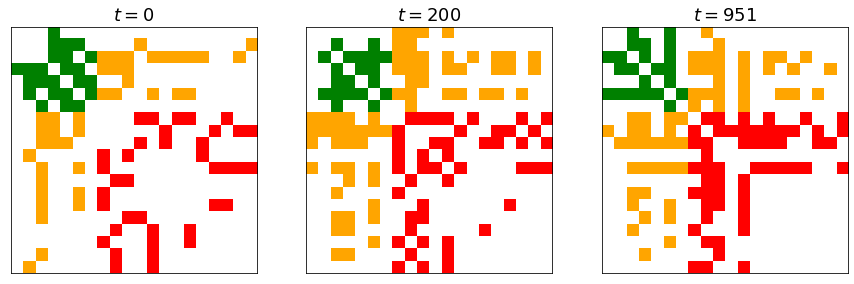

In [103]:
colors = ['white','red','orange','green']
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

fig,axs=plt.subplots(figsize=(15,5),ncols=3)
axs[0].imshow(A0,cmap=my_cmap)
axs[0].set_title('$t=0$')

axs[1].imshow(A1,cmap=my_cmap)
axs[1].set_title('$t=200$')

axs[2].imshow(A2,cmap=my_cmap)
axs[2].set_title('$t=951$')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# fig.savefig("Data/FixedStrategy/Core-Periphery evolution ER.pdf")